<a href="https://colab.research.google.com/github/INVISIBLE-SAM/PROJECT/blob/main/Copy_of_Alzheimer_prediction_using_tl_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'oasis-alzheimer-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4579101%2F7816343%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T091456Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da80e515a03c1102b746ee6c6bb7b263ad9603efada4ccbfdfec10494bfd212d44d6df4e5986ff72fff2fd0f47d6cdfc13680a0b4850f23e6328b7acc017905334dfbc3461ea4ae9bdc01203b96d0af39abbd47606bb2d83eeb4aabcbee0ecbf9197d424b06cb59452dcf0aed4f5c50ad06794ec5929e1c8e3f9697102ad789ed498cfe1a66cecd25542996e4612180119a8db40f50a1c268bfcb5cb887e59abe67377f27884b354ff8046fc3cd2ff61cabd994e0d2f7bfa9d92197261803e87bb4e257cd4c9e3060191ff62d37541059ae77c9813ea31c97232026ad93819c397aa20768d8cf7cf19416964f62a31b008cbfc6685d5e859aa3fbad28efc15eb8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1322156281 bytes downloaded
Downloaded and uncompressed: oasis-alzheimer-dataset
Data source import complete.


In [ ]:
import numpy as np
import os
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
Conv=keras.applications.NASNetLarge(input_shape=[224,224,3],weights='imagenet',include_top=False)
for layer in Conv.layers:
    layer.trainable=False

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
x=Flatten()(Conv.output)
prediction=Dense(4,activation='softmax')(x)
model=Model(inputs=Conv.input,outputs=prediction)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 96)   │          2,592 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activat

 Total params: 85,707,094 (326.95 MB)

 Trainable params: 790,276 (3.01 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1.0/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

traning_set=train_datagen.flow_from_directory('/kaggle/input/oasis-alzheimer-dataset/train',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')
test_set=test_datagen.flow_from_directory('/kaggle/input/oasis-alzheimer-dataset/test',
                                         target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.


Epoch 1/3
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1262s 557ms/step - accuracy: 0.7547 - loss: 4.1345 - val_accuracy: 0.8094 - val_loss: 3.1004
Epoch 2/3
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 56s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8149 - val_loss: 3.0303
Epoch 3/3
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1213s 534ms/step - accuracy: 0.8268 - loss: 3.0806 - val_accuracy: 0.8645 - val_loss: 2.4018


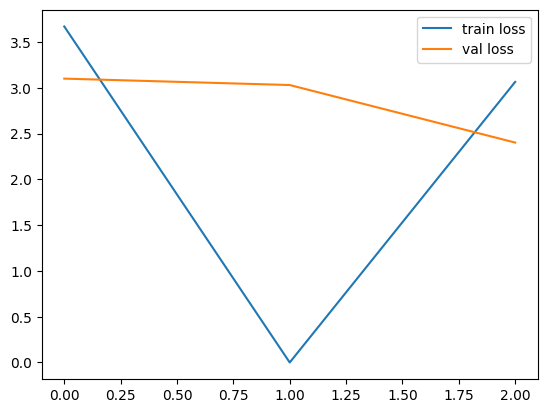

<Figure size 640x480 with 0 Axes>

In [ ]:
r=model.fit(traning_set,validation_data=test_set,epochs=3,steps_per_epoch=len(traning_set),validation_steps=400)


plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

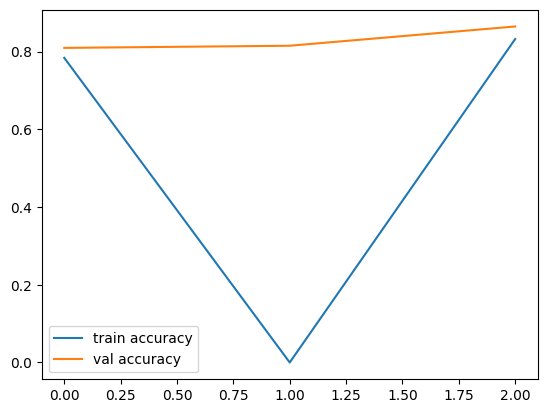

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')